## Импортируем библиотеки

In [80]:
import matplotlib.pyplot as plt  # для построения графиков
import torch  # фреймворк для машинного обучения
import torch.nn as nn
import numpy as np
import pandas as pd  # для работы с датафреймами
from sklearn.model_selection import train_test_split  # функция для сплита датасета
from torchmetrics import ConfusionMatrix
import datetime
import seaborn as sns

## Импортируем исходный датасет

Если по какой-то причине не будет импортироваться датасет с гитхаба, то импортируем вручную:

`
df = pd.read_csv('df_toxicity_properties.csv', sep=',')
`

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/artchemi/drug_disease/main/df_toxicity_properties.csv', sep=',')

In [3]:
df

,mouse_oral_LD50,aromatic,molecular_weight,xlogp,tpsa,complexity,charge,h_bond_donor_count,h_bond_acceptor_count,rotatable_bond_count,atom_stereo_count,canonical_smiles,f_count,cl_count,br_count,i_count,pb_count,hg_count
0,2.652669,1.0,110.11,0.6,40.5,54.9,0.0,2.0,2.0,0.0,0.0,Oc1ccc(O)cc1,0,0,0,0,0,0
1,3.697193,0.0,189.22,0.5,41.1,194.0,0.0,0.0,4.0,3.0,0.0,S=P(N1CC1)(N1CC1)N1CC1,0,0,0,0,0,0
2,3.726179,0.0,290.80,3.8,0.0,104.0,0.0,0.0,0.0,0.0,0.0,ClC1C(Cl)C(Cl)C(Cl)C(Cl)C1Cl,0,6,0,0,0,0
3,1.949784,0.0,129.16,-1.3,91.5,132.0,0.0,3.0,1.0,2.0,0.0,CN(C)C(=N)N=C(N)N,0,0,0,0,0,0
4,1.471764,1.0,148.16,2.1,37.3,155.0,0.0,1.0,2.0,2.0,0.0,O=C(O)C=Cc1ccccc1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20144,2.333925,0.0,198.31,0.5,67.6,167.0,0.0,2.0,2.0,3.0,0.0,N=C(N)NCCN1CCCCCCC1,0,0,0,0,0,0
20145,3.132693,3.0,404.50,2.3,76.9,571.0,0.0,0.0,4.0,6.0,1.0,O=C1C(CCS(=O)c2ccccc2)C(=O)N(c2ccccc2)N1c1ccccc1,0,0,0,0,0,0
20146,1.255649,0.0,180.16,-3.7,121.0,104.0,0.0,6.0,6.0,0.0,0.0,OC1C(O)C(O)C(O)C(O)C1O,0,0,0,0,0,0
20147,2.427583,3.0,495.20,3.9,71.0,581.0,0.0,1.0,5.0,7.0,0.0,Cc1nc2c(Br)cc(Br)cc2c(=O)n1CCOC(=O)CNc1ccccc1,0,0,2,0,0,0


## Очищаем датасет от нулей

В датасете некоторые свойства не парсятся с pubchem, поэтому от них нужно избавиться

In [4]:
df = df[(df.xlogp != 0) & (df.tpsa != 0) & (df.complexity != 0) & (df.molecular_weight != 0)]

In [5]:
df

,mouse_oral_LD50,aromatic,molecular_weight,xlogp,tpsa,complexity,charge,h_bond_donor_count,h_bond_acceptor_count,rotatable_bond_count,atom_stereo_count,canonical_smiles,f_count,cl_count,br_count,i_count,pb_count,hg_count
0,2.652669,1.0,110.11,0.6,40.5,54.9,0.0,2.0,2.0,0.0,0.0,Oc1ccc(O)cc1,0,0,0,0,0,0
1,3.697193,0.0,189.22,0.5,41.1,194.0,0.0,0.0,4.0,3.0,0.0,S=P(N1CC1)(N1CC1)N1CC1,0,0,0,0,0,0
3,1.949784,0.0,129.16,-1.3,91.5,132.0,0.0,3.0,1.0,2.0,0.0,CN(C)C(=N)N=C(N)N,0,0,0,0,0,0
4,1.471764,1.0,148.16,2.1,37.3,155.0,0.0,1.0,2.0,2.0,0.0,O=C(O)C=Cc1ccccc1,0,0,0,0,0,0
5,0.573216,0.0,156.26,3.8,17.1,78.9,0.0,0.0,1.0,8.0,0.0,CCCCCCCCCC=O,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20144,2.333925,0.0,198.31,0.5,67.6,167.0,0.0,2.0,2.0,3.0,0.0,N=C(N)NCCN1CCCCCCC1,0,0,0,0,0,0
20145,3.132693,3.0,404.50,2.3,76.9,571.0,0.0,0.0,4.0,6.0,1.0,O=C1C(CCS(=O)c2ccccc2)C(=O)N(c2ccccc2)N1c1ccccc1,0,0,0,0,0,0
20146,1.255649,0.0,180.16,-3.7,121.0,104.0,0.0,6.0,6.0,0.0,0.0,OC1C(O)C(O)C(O)C(O)C1O,0,0,0,0,0,0
20147,2.427583,3.0,495.20,3.9,71.0,581.0,0.0,1.0,5.0,7.0,0.0,Cc1nc2c(Br)cc(Br)cc2c(=O)n1CCOC(=O)CNc1ccccc1,0,0,2,0,0,0


## Собираем статистику по датасету

<AxesSubplot:xlabel='mouse_oral_LD50', ylabel='Count'>

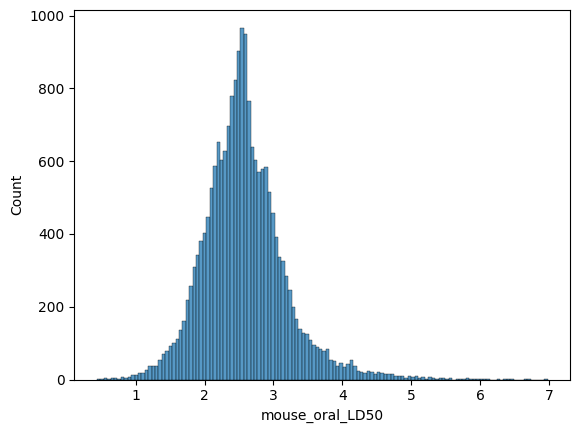

In [6]:
sns.histplot(df.mouse_oral_LD50)

<AxesSubplot:xlabel='molecular_weight', ylabel='Count'>

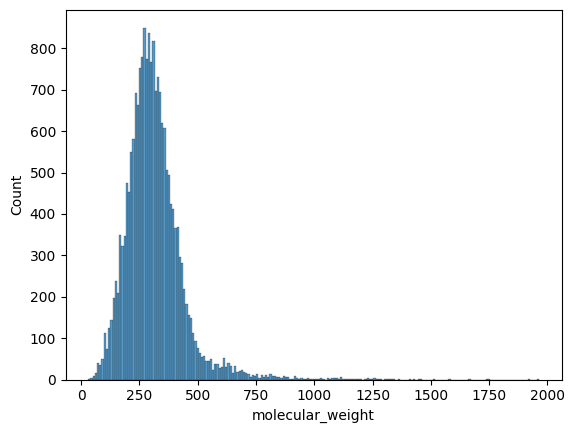

In [7]:
sns.histplot(df.molecular_weight)

<AxesSubplot:xlabel='tpsa', ylabel='Count'>

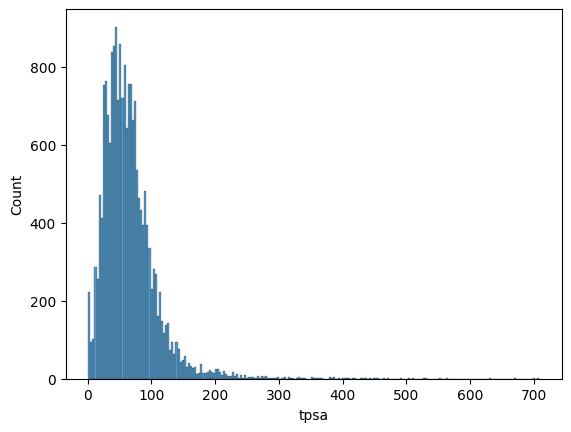

In [8]:
sns.histplot(df.tpsa)
# TPSA - topological polar surface area

<AxesSubplot:xlabel='xlogp', ylabel='Count'>

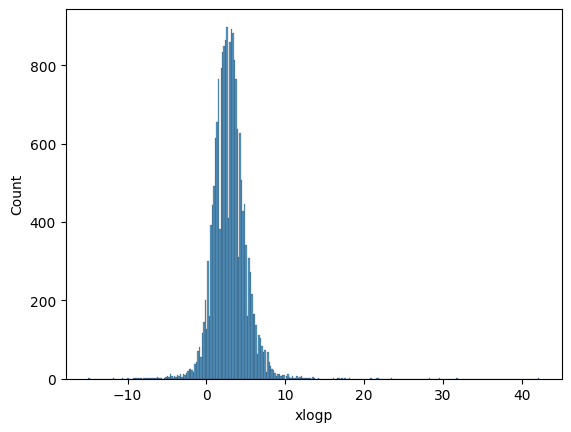

In [9]:
sns.histplot(df.xlogp)
# xlogp - липофильность

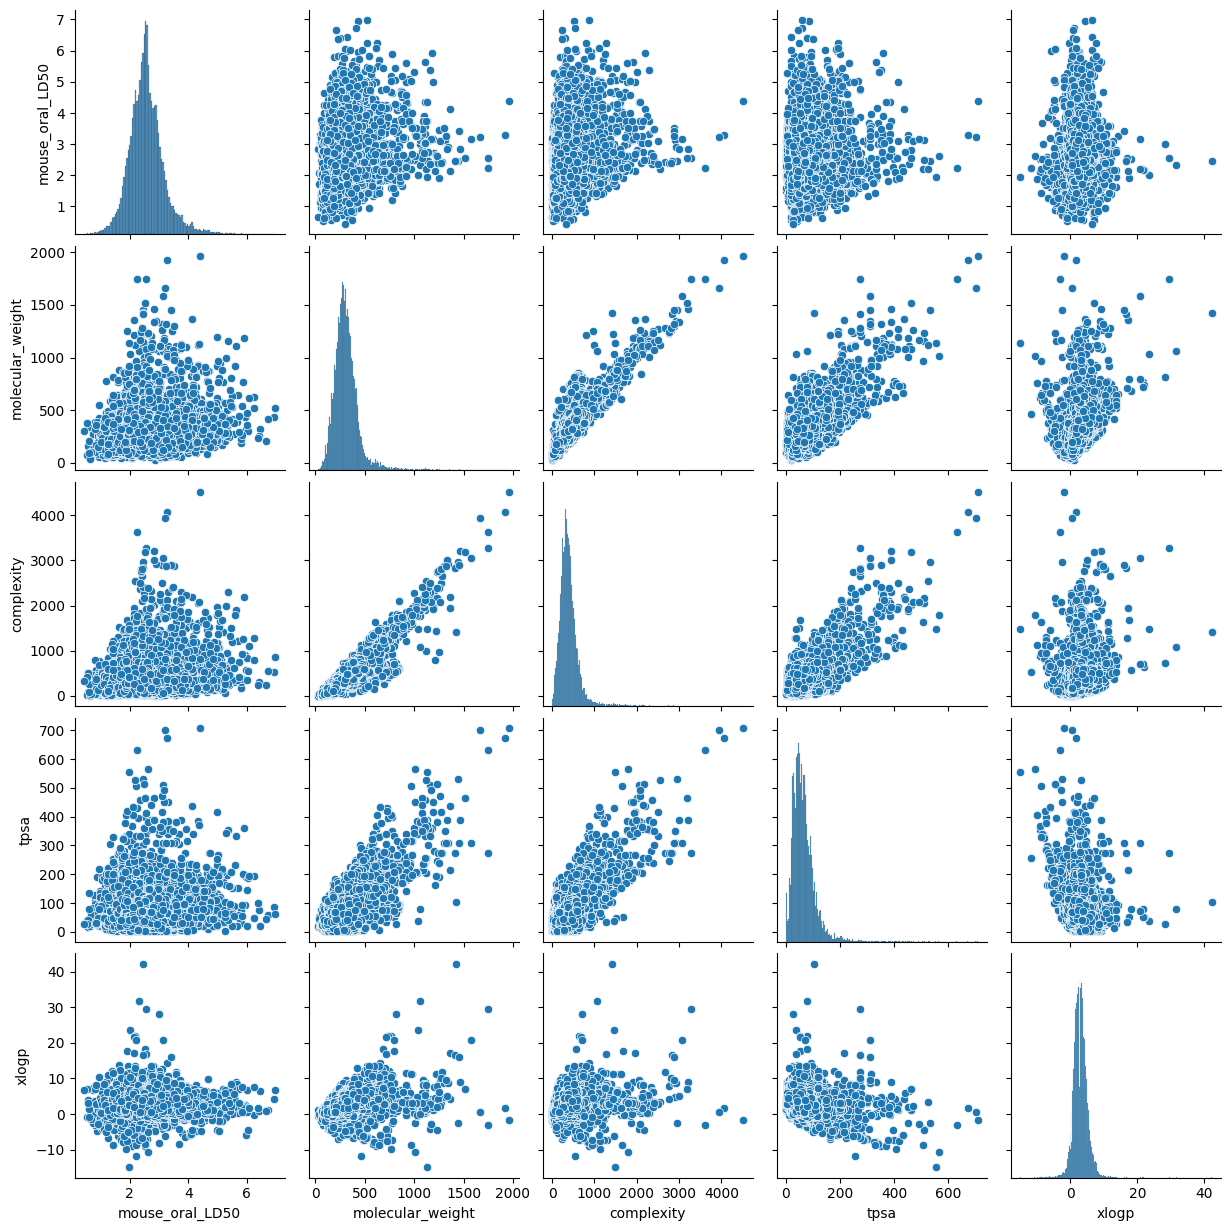

In [47]:
sns.pairplot(df[['mouse_oral_LD50', 'molecular_weight', 'complexity', 'tpsa', 'xlogp']])

<AxesSubplot:>

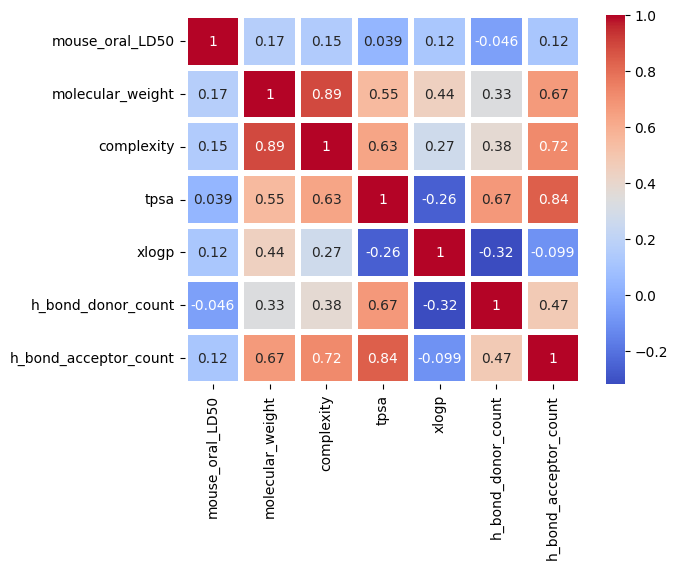

In [53]:
sns.heatmap(df[['mouse_oral_LD50', 'molecular_weight', 'complexity', 'tpsa', 'xlogp', 'h_bond_donor_count', 'h_bond_acceptor_count']].corr(),
            annot=True, cmap='coolwarm', linewidths=3)

## Получаем классы

In [10]:
# 0 - non-toxic, 1 - toxic
tox_class = []
for tox in df.mouse_oral_LD50:
    if tox < 2.5:
        tox_class.append(1.0)
    else:
        tox_class.append(0.0)

In [11]:
df['tox_class'] = tox_class

C:\Users\artda\AppData\Local\Temp\ipykernel_22416\3942029030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tox_class'] = tox_class


In [12]:
df = df.set_index(np.arange(df.shape[0]))

In [13]:
df

,mouse_oral_LD50,aromatic,molecular_weight,xlogp,tpsa,complexity,charge,h_bond_donor_count,h_bond_acceptor_count,rotatable_bond_count,atom_stereo_count,canonical_smiles,f_count,cl_count,br_count,i_count,pb_count,hg_count,tox_class
0,2.652669,1.0,110.11,0.6,40.5,54.9,0.0,2.0,2.0,0.0,0.0,Oc1ccc(O)cc1,0,0,0,0,0,0,0.0
1,3.697193,0.0,189.22,0.5,41.1,194.0,0.0,0.0,4.0,3.0,0.0,S=P(N1CC1)(N1CC1)N1CC1,0,0,0,0,0,0,0.0
2,1.949784,0.0,129.16,-1.3,91.5,132.0,0.0,3.0,1.0,2.0,0.0,CN(C)C(=N)N=C(N)N,0,0,0,0,0,0,1.0
3,1.471764,1.0,148.16,2.1,37.3,155.0,0.0,1.0,2.0,2.0,0.0,O=C(O)C=Cc1ccccc1,0,0,0,0,0,0,1.0
4,0.573216,0.0,156.26,3.8,17.1,78.9,0.0,0.0,1.0,8.0,0.0,CCCCCCCCCC=O,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19792,2.333925,0.0,198.31,0.5,67.6,167.0,0.0,2.0,2.0,3.0,0.0,N=C(N)NCCN1CCCCCCC1,0,0,0,0,0,0,1.0
19793,3.132693,3.0,404.50,2.3,76.9,571.0,0.0,0.0,4.0,6.0,1.0,O=C1C(CCS(=O)c2ccccc2)C(=O)N(c2ccccc2)N1c1ccccc1,0,0,0,0,0,0,0.0
19794,1.255649,0.0,180.16,-3.7,121.0,104.0,0.0,6.0,6.0,0.0,0.0,OC1C(O)C(O)C(O)C(O)C1O,0,0,0,0,0,0,1.0
19795,2.427583,3.0,495.20,3.9,71.0,581.0,0.0,1.0,5.0,7.0,0.0,Cc1nc2c(Br)cc(Br)cc2c(=O)n1CCOC(=O)CNc1ccccc1,0,0,2,0,0,0,1.0


## Собираем тензоры из датасета

In [14]:
y_lst = [[y] for y in df.tox_class]
Y = torch.tensor(y_lst)

In [15]:
Y

tensor([[0.],
        [0.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])

In [16]:
x_lst = []
for i in range(0, df.shape[0]):
    f = float(df['f_count'].loc[i])
    cl = float(df['cl_count'].loc[i])
    br = float(df['br_count'].loc[i])
    iod = float(df['i_count'].loc[i])

    pb = float(df['pb_count'].loc[i])
    hg = float(df['hg_count'].loc[i])

    row_x = [float(df['molecular_weight'].loc[i]), df.tpsa.loc[i], df.xlogp.loc[i], df.complexity.loc[i],
             df.rotatable_bond_count.loc[i], df.atom_stereo_count.loc[i], df.h_bond_donor_count.loc[i],
             df.h_bond_acceptor_count.loc[i], f+cl+br+iod, pb+hg]
    x_lst.append(row_x)

In [17]:
X = torch.tensor(x_lst)
X = X.float()

In [18]:
X

tensor([[110.1100,  40.5000,   0.6000,  ...,   2.0000,   0.0000,   0.0000],
        [189.2200,  41.1000,   0.5000,  ...,   4.0000,   0.0000,   0.0000],
        [129.1600,  91.5000,  -1.3000,  ...,   1.0000,   0.0000,   0.0000],
        ...,
        [180.1600, 121.0000,  -3.7000,  ...,   6.0000,   0.0000,   0.0000],
        [495.2000,  71.0000,   3.9000,  ...,   5.0000,   2.0000,   0.0000],
        [318.5000,  40.6000,   3.6000,  ...,   2.0000,   0.0000,   0.0000]])

In [19]:
X.shape, Y.shape

(torch.Size([19797, 10]), torch.Size([19797, 1]))

## Разбиваем тензоры на обучающий и тестовый

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)

In [21]:
print(f'Размерность обучающей выборки: {X_train.shape, Y_train.shape}\nРазмерность тестовой выборки: {X_test.shape, Y_test.shape}')

Размерность обучающей выборки: (torch.Size([14847, 10]), torch.Size([14847, 1]))
Размерность тестовой выборки: (torch.Size([4950, 10]), torch.Size([4950, 1]))


## PCA

In [22]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [23]:
X_dec = np.array(x_lst)
Y_dec = np.array(df.tox_class)

In [25]:
pca = PCA(n_components=2)

In [26]:
X_r = pca.fit(X_dec).transform(X_dec)

In [27]:
lda = LinearDiscriminantAnalysis(n_components=2)

In [28]:
X_r[Y_dec == 0].shape

(10613, 2)

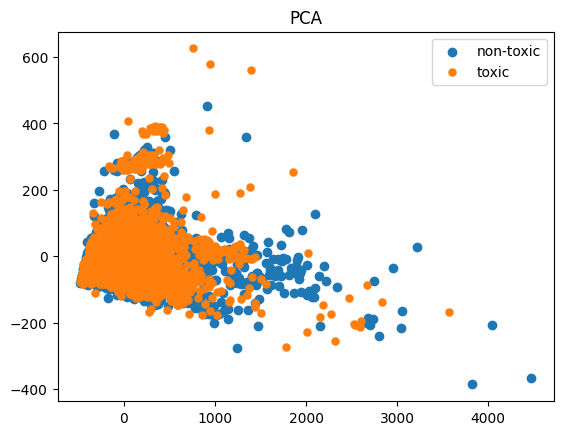

In [29]:
plt.scatter(X_r[Y_dec == 0, 0], X_r[Y_dec == 0, 1], label='non-toxic')
plt.scatter(X_r[Y_dec == 1, 0], X_r[Y_dec == 1, 1], label='toxic',
            linewidth=0.1)
plt.title('PCA')
plt.legend()

## Модель

In [30]:
nX, nH, nY = 10, 30, 1

model = nn.Sequential(nn.Linear(nX, nH),
                      nn.Sigmoid(),  # функция активации
                      nn.Linear(nH, nY),
                      nn.Sigmoid())

In [31]:
class TwoLayersNet(nn.Module):
    def __init__(self, nX, nH, nY):
        super(TwoLayersNet, self).__init__()
        self.fc1 = nn.Linear(nX, nH)
        self.fc2 = nn.Linear(nH, nY)

    def forward(self, x):
        x = self.fc1(x)
        x = nn.Sigmoid()(x)
        x = self.fc2(x)
        x = nn.Sigmoid()(x)
        return x

In [32]:
model = TwoLayersNet(nX, nH, nY)

In [37]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.1)
loss = nn.BCELoss()

In [38]:
state = torch.load('state.pt')           
 
model = TwoLayersNet(nX, nH, nY)                        
 
model.load_state_dict(state['model'])        
optimizer.load_state_dict(state['optimizer'])    
 
print(state['info'], state['date']) 

Это моя сеть 2023-05-24 14:52:10.767499


In [39]:
loss(model(X_train), Y_train)

tensor(0.6706, grad_fn=<BinaryCrossEntropyBackward0>)

In [40]:
print(model)

TwoLayersNet(
  (fc1): Linear(in_features=10, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=1, bias=True)
)


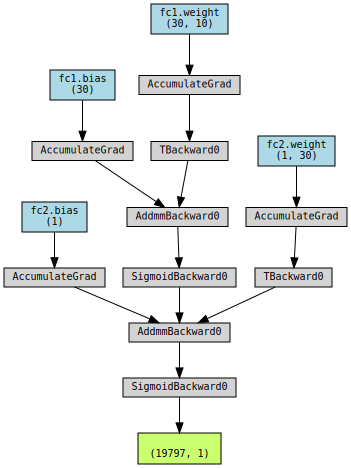

In [41]:
import torchviz
      
torchviz.make_dot(model(X),  
                  params = dict(model.named_parameters()) )

## Confusion matrix на обучающем датасете

In [81]:
confmat_train = ConfusionMatrix(task="binary", num_classes=2)
confmat_train(model(X_train), Y_train)

tensor([[4189, 3682],
        [2719, 4257]])

In [82]:
df_cm_train = pd.DataFrame(confmat(model(X_train), Y_train), 
                           columns=['Pred_Negative', 'Pred_Positive'], 
                           index=['Negative', 'Positive'])

<AxesSubplot:>

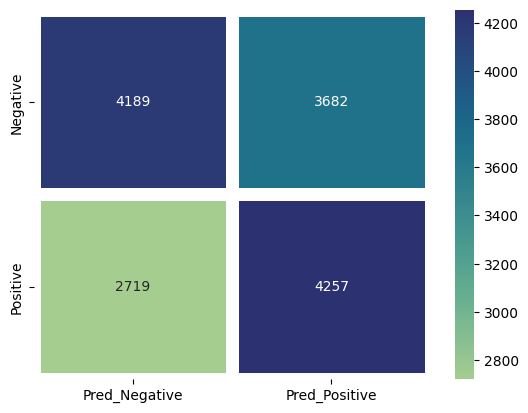

In [83]:
sns.heatmap(df_cm_train, annot=True, fmt='.4g', linewidth=8, cmap='crest')

## Confusion matrix на тестовом датасете

In [55]:
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat(model(X_test), Y_test)

tensor([[1429, 1313],
        [ 920, 1288]])

In [60]:
df_cm_test = pd.DataFrame(confmat(model(X_test), Y_test), 
                          columns=['Pred_Negative', 'Pred_Positive'], 
                          index=['Negative', 'Positive'])

<AxesSubplot:>

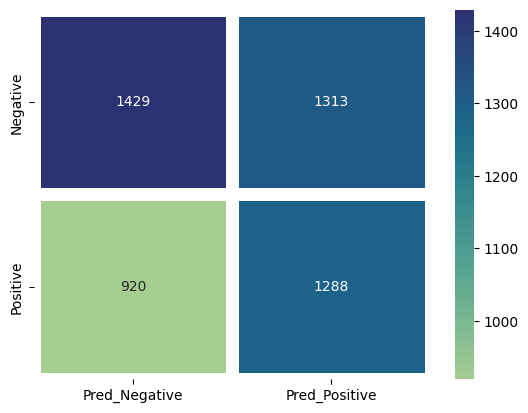

In [79]:
sns.heatmap(df_cm_test, annot=True, fmt='.4g', linewidth=8, cmap='crest')